# "Pop" Vs. "Soda" Vs. "Coke" in the 50 States: An Exploration

Bringing in our packages for today

In [ ]:
!pip install pysal

In [14]:
from bs4 import BeautifulSoup
import requests as rq
import numpy as np
import pandas as pd
import plotly.express as px
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights
from matplotlib import pyplot as plt

## Dataset

In [15]:
url = 'https://popvssoda.com/statistics/ALL.html'

In [16]:
rq.get(url).status_code

200

### Webscraping with `requests` and `BeautifulSoup`

In [17]:
content = rq.get(url).content

In [18]:
soup = BeautifulSoup(content)

In [19]:
data = soup.find('table')

In [20]:
cols = []
ctr = 1
for row in data.find_all('tr'):
    
    if ctr > 1:
        break
    for elem in row.find_all('td'):
        cols.append(elem.text)
    ctr += 1

In [21]:
cols

['pop', 'soda', 'coke', 'other', 'Total']

In [22]:
cols.append('Pct')
cols = ['State'] + cols

In [23]:
clean = []

for row in data.find_all('tr'):
    
    state = []
    state.append(row.find('th').text)
    for elem in row.find_all('td'):
        state.append(elem.text)
    clean.append(state)
    

### Constructing a DataFrame

In [25]:
df = pd.DataFrame(clean, columns=cols)

In [26]:
df.head()

,State,pop,soda,coke,other,Total,Pct
0,State/Province,pop,soda,coke,other,Total,None
1,Total,157659,164145,58490,21120,401414,100.00%
2,Alabama,153,582,2849,665,4249,1.06%
3,Alaska,324,636,60,92,1112,0.28%
4,Alberta,2185,69,55,48,2357,0.59%


In [28]:
df = df.drop([0, 1])

In [29]:
df.shape

(69, 7)

In [30]:
df.head()

,State,pop,soda,coke,other,Total,Pct
2,Alabama,153,582,2849,665,4249,1.06%
3,Alaska,324,636,60,92,1112,0.28%
4,Alberta,2185,69,55,48,2357,0.59%
5,American Samoa,8,11,1,40,60,0.01%
6,Arizona,586,2799,437,174,3996,1.00%


#### Saving for Later

In [31]:
df.to_csv('pop_soda_data.csv')

## Cleaning Up

In [32]:
df.dtypes

State    object
pop      object
soda     object
coke     object
other    object
Total    object
Pct      object
dtype: object

### Converting to Numbers

In [33]:
df2 = df.copy()
for col in df2.columns[1:-1]:
    df2[col] = df2[col].map(int)
df2['Pct'] = df2['Pct'].map(lambda x: float(x[:-1])/100)

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 2 to 70
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   69 non-null     object 
 1   pop     69 non-null     int64  
 2   soda    69 non-null     int64  
 3   coke    69 non-null     int64  
 4   other   69 non-null     int64  
 5   Total   69 non-null     int64  
 6   Pct     69 non-null     float64
dtypes: float64(1), int64(5), object(1)
memory usage: 4.3+ KB


### Converting to State Abbreviations for `plotly`

In [35]:
# source = https://gist.github.com/rogerallen/1583593

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

In [36]:
df2['State'] = df2['State'].map(us_state_to_abbrev)

## Plotting

Let's try using `plotly` to show what "Pop" usage looks like in the USA.

In [37]:
map_ = px.choropleth(locations='State',
              color='pop',
              data_frame=df2,
              locationmode='USA-states',
              scope='usa',
              title="'Pop' by State")
map_.show()

### Improvements

This map is a bit misleading since it's using pure population numbers. We can get a better sense of usage by looking at state *percentages*.

In [38]:
df2['pop_pct'] = df2['pop'] / df2['Total']
df2['soda_pct'] = df2['soda'] / df2['Total']
df2['coke_pct'] = df2['coke'] / df2['Total']
df2['other_pct'] = df2['other'] / df2['Total']

Let's now look at "Pop", "Soda" and "Coke" usage, based on percentages this time.

In [39]:
map_ = px.choropleth(locations='State',
              color='pop_pct',
              data_frame=df2,
              locationmode='USA-states',
              scope='usa',
              title="'Pop' by State")
map_.show()

In [40]:
map_ = px.choropleth(locations='State',
              color='soda_pct',
              data_frame=df2,
              locationmode='USA-states',
              scope='usa',
              title="'Soda' by State")
map_.show()

In [41]:
map_ = px.choropleth(locations='State',
              color='coke_pct',
              data_frame=df2,
              locationmode='USA-states',
              scope='usa',
              title="'Coke' by State")
map_.show()

## Looking for Spatial Correlations

Weight Matrix for Use with Moran's *I* Statistic

In [42]:
# Source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
# Don't forget to upload this file to the workspace!

state_shape = gpd.read_file('cb_2018_us_state_5m.zip')

In [43]:
state_shape

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."
5,06,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"MULTIPOLYGON (((-118.60337 33.47810, -118.5987..."
6,21,01779786,0400000US21,21,KY,Kentucky,00,102279490672,2375337755,"MULTIPOLYGON (((-89.40565 36.52817, -89.39869 ..."
7,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.73571 41.60336, -82.71880 ..."
8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ..."
9,13,01705317,0400000US13,13,GA,Georgia,00,149482048342,4422936154,"POLYGON ((-85.60516 34.98468, -85.55259 34.984..."


Let's get rid of the non-states.

In [44]:
just_states = state_shape.sort_values('NAME').drop([39, 46, 47, 48, 49, 51]).reset_index()

In [45]:
just_states

,index,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ..."
1,55,02,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ..."
2,28,04,01779777,0400000US04,04,AZ,Arizona,00,294198551143,1027337603,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
3,52,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.55929 36.499..."
4,5,06,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"MULTIPOLYGON (((-118.60337 33.47810, -118.5987..."
5,31,08,01779779,0400000US08,08,CO,Colorado,00,268422891711,1181621593,"POLYGON ((-109.06025 38.59933, -109.05954 38.7..."
6,40,09,01779780,0400000US09,09,CT,Connecticut,00,12542497068,1815617571,"POLYGON ((-73.72777 41.10070, -73.69595 41.115..."
7,29,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"MULTIPOLYGON (((-75.57080 39.62677, -75.55945 ..."
8,38,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.75164 24.85725, -80.72906 ..."
9,9,13,01705317,0400000US13,13,GA,Georgia,00,149482048342,4422936154,"POLYGON ((-85.60516 34.98468, -85.55259 34.984..."


### Determining Neighbors

The "Rook" method will simply take states that border each other as neighbors -- no diagonals, just like the Rook in a game of chess. The geometry column of our shapefiles has this information.

In [46]:
neighbors = weights.Rook.from_dataframe(just_states)

We can access what neighbors what according to our shapefile.

In [47]:
# Alaska (State #1) borders no states, while Alabama (State #0) borders
# Florida (State #8), Georgia (State #9), Mississippi (State #23), and
# Tennessee (State #41). Let's see if we can observe these relations
# below.

neighbors.neighbors

{0: [8, 41, 9, 23],
 1: [],
 2: [27, 43, 4, 30],
 3: [17, 35, 23, 24, 41, 42],
 4: [2, 27, 36],
 5: [49, 35, 26, 43, 30, 15],
 6: [20, 38, 31],
 7: [29, 19, 37],
 8: [0, 9],
 9: [0, 32, 39, 8, 41],
 10: [],
 11: [49, 36, 27, 25, 43, 46],
 12: [48, 16, 24, 13, 14],
 13: [16, 34, 12, 21],
 14: [48, 22, 40, 24, 26, 12],
 15: [24, 26, 35, 5],
 16: [34, 45, 24, 41, 12, 13, 47],
 17: [42, 3, 23],
 18: [28],
 19: [47, 45, 37, 7],
 20: [6, 38, 44, 28, 31],
 21: [48, 34, 13],
 22: [48, 33, 40, 14],
 23: [0, 17, 3, 41],
 24: [3, 35, 41, 12, 14, 15, 16, 26],
 25: [40, 33, 11, 49],
 26: [49, 5, 24, 40, 14, 15],
 27: [2, 4, 36, 43, 11],
 28: [18, 20, 44],
 29: [31, 37, 7],
 30: [2, 35, 42, 5],
 31: [20, 37, 6, 44, 29],
 32: [9, 41, 45, 39],
 33: [40, 25, 22],
 34: [16, 21, 37, 13, 47],
 35: [3, 5, 24, 42, 30, 15],
 36: [11, 27, 4, 46],
 37: [34, 19, 7, 31, 29, 47],
 38: [20, 6],
 39: [32, 9],
 40: [33, 49, 22, 25, 26, 14],
 41: [0, 32, 3, 9, 45, 16, 23, 24],
 42: [17, 3, 35, 30],
 43: [49, 2, 5, 11

Again let's get rid of the non-states, this time in our "pop/soda" DataFrame.

In [48]:
df2['state_bin'] = df2['State'].map(lambda x: 1 if x in us_state_to_abbrev.values() else 0)

In [49]:
pop_df = df2[df2['state_bin'] == 1].reset_index()

### Calculating Local Indicators of Spatial Association (LISA)

In [50]:
# Source: https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

lisa_pop = esda.moran.Moran_Local(pop_df['pop_pct'], neighbors)
lisa_soda = esda.moran.Moran_Local(pop_df['soda_pct'], neighbors)
lisa_coke = esda.moran.Moran_Local(pop_df['coke_pct'], neighbors)

('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')


In [51]:
# Actual values of Moran's I

lisa_pop.Is

array([ 0.80007937, -0.        ,  0.27455302,  0.45140772,  0.08654382,
        0.4136932 ,  0.61986593,  0.34936131,  0.83462268,  0.8441776 ,
       -0.        ,  0.53542073,  0.48617525,  0.93858317,  1.56919502,
        0.71948456, -0.040244  ,  0.80971695,  0.91359779, -0.04422347,
        0.7397562 ,  0.95828518,  2.09758574,  0.75437431, -0.17478778,
        1.60419972,  1.42211217, -0.08523648,  0.92023305,  0.06837091,
        0.0596569 ,  0.00764232,  0.77048278,  2.5524784 ,  1.34250519,
       -0.05484877,  0.11307189,  0.01470376,  0.92464088,  0.8473736 ,
        2.1647841 ,  0.59729745,  0.50081092,  0.05146162,  0.60401778,
        0.24108275,  1.04842945,  0.16085621, -0.16988724,  0.55780964])

### *p*-Values

In [52]:
lisa_pop.p_sim

array([0.032, 0.001, 0.136, 0.054, 0.428, 0.086, 0.14 , 0.228, 0.09 ,
       0.013, 0.001, 0.06 , 0.156, 0.024, 0.012, 0.108, 0.111, 0.085,
       0.023, 0.481, 0.035, 0.064, 0.009, 0.04 , 0.06 , 0.008, 0.012,
       0.385, 0.008, 0.463, 0.446, 0.061, 0.032, 0.002, 0.037, 0.401,
       0.383, 0.434, 0.006, 0.108, 0.001, 0.013, 0.12 , 0.307, 0.136,
       0.248, 0.105, 0.34 , 0.001, 0.001])

In [53]:
lisa_soda.p_sim

array([0.074, 0.001, 0.142, 0.038, 0.186, 0.046, 0.024, 0.036, 0.105,
       0.162, 0.001, 0.266, 0.309, 0.068, 0.246, 0.273, 0.136, 0.025,
       0.131, 0.2  , 0.002, 0.262, 0.17 , 0.001, 0.002, 0.05 , 0.095,
       0.224, 0.009, 0.074, 0.335, 0.006, 0.29 , 0.03 , 0.069, 0.175,
       0.26 , 0.082, 0.027, 0.356, 0.001, 0.104, 0.028, 0.442, 0.035,
       0.326, 0.346, 0.497, 0.072, 0.081])

In [54]:
lisa_coke.p_sim

array([0.001, 0.001, 0.43 , 0.002, 0.328, 0.486, 0.046, 0.218, 0.02 ,
       0.007, 0.001, 0.073, 0.338, 0.343, 0.006, 0.318, 0.489, 0.001,
       0.256, 0.252, 0.004, 0.32 , 0.001, 0.001, 0.13 , 0.071, 0.065,
       0.161, 0.03 , 0.099, 0.178, 0.009, 0.012, 0.018, 0.407, 0.069,
       0.23 , 0.088, 0.168, 0.044, 0.004, 0.001, 0.003, 0.193, 0.074,
       0.096, 0.235, 0.415, 0.006, 0.043])

### Plotting the Significant Values

#### "Pop"

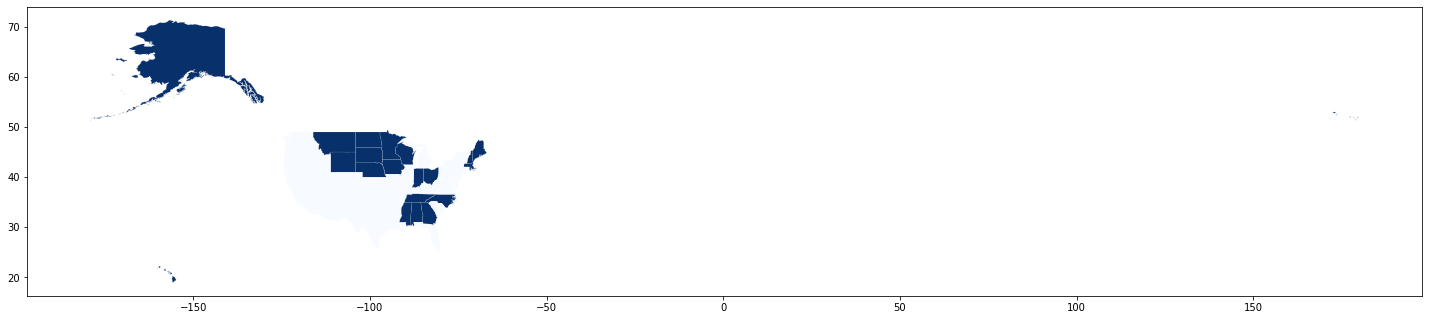

In [118]:
# Source: https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

# Set up figure and axes
f, ax = plt.subplots(figsize=(25, 12))

labels = pd.Series(
    1 * (lisa_pop.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=just_states.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
just_states.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Blues",
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=ax,
)
plt.show()

In [86]:
map_ = px.choropleth(locations='State',
              color='pop_pct',
              data_frame=df2,
              locationmode='USA-states',
              scope='usa',
              title="'Pop' by State")
map_.show()

#### "Soda"

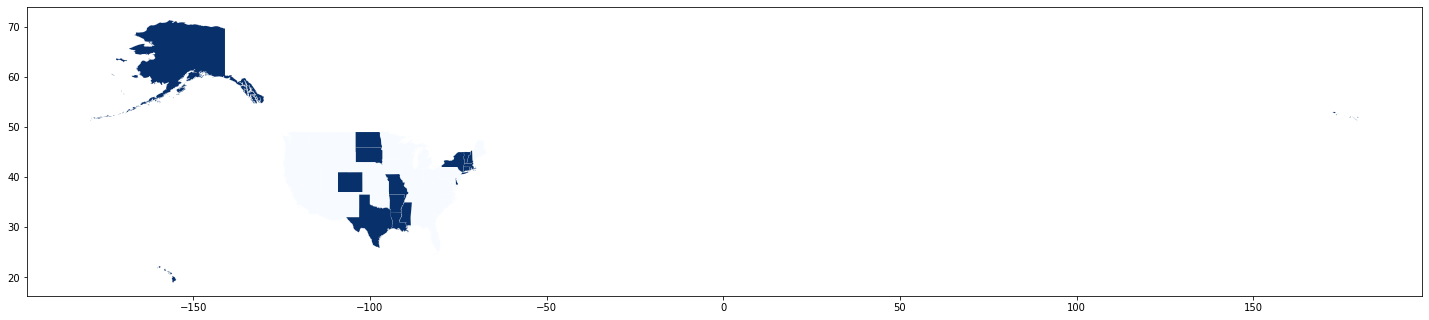

In [124]:
f, ax = plt.subplots(figsize=(25, 12))

labels2 = pd.Series(
    1 * (lisa_soda.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=just_states.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})

just_states.assign(
    cl=labels2
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Blues",
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=ax
)
plt.show()

In [125]:
map_ = px.choropleth(locations='State',
              color='soda_pct',
              data_frame=df2,
              locationmode='USA-states',
              scope='usa',
              title="'Soda' by State")
map_.show()

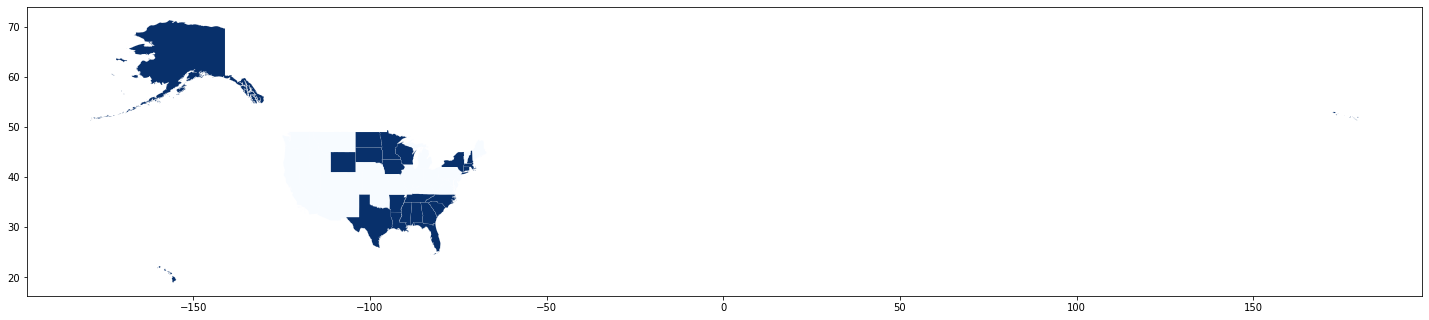

In [131]:
f, ax = plt.subplots(figsize=(25, 12))

labels3 = pd.Series(
    1 * (lisa_coke.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=just_states.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})

just_states.assign(
    cl=labels3
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Blues",
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=ax
)
plt.show()

In [127]:
map_ = px.choropleth(locations='State',
              color='coke_pct',
              data_frame=df2,
              locationmode='USA-states',
              scope='usa',
              title="'Coke' by State")
map_.show()